In [11]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

from snorkel import SnorkelSession
session = SnorkelSession()

# Here, we just set how many documents we'll process for automatic testing- you can safely ignore this!
n_docs = 500 if 'CI' in os.environ else 2591

from snorkel.models import candidate_subclass

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

train_cands = session.query(Spouse).filter(Spouse.split == 0).order_by(Spouse.id).all()
dev_cands   = session.query(Spouse).filter(Spouse.split == 1).order_by(Spouse.id).all()
test_cands  = session.query(Spouse).filter(Spouse.split == 2).order_by(Spouse.id).all()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from util import load_external_labels

%time load_external_labels(session, Spouse, annotator_name='gold')

from snorkel.annotations import load_gold_labels

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, zero_one=True)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, zero_one=True)

AnnotatorLabels created: 0
AnnotatorLabels created: 0
CPU times: user 2min 45s, sys: 1.86 s, total: 2min 46s
Wall time: 2min 46s


In [12]:
#gold_labels_dev = [x[0,0] for x in L_gold_dev.todense()]
#for i,L in enumerate(gold_labels_dev):
#    print(i,gold_labels_dev[i])

gold_labels_dev = []
for i,L in enumerate(L_gold_dev):
    gold_labels_dev.append(L[0,0])
    
gold_labels_test = []
for i,L in enumerate(L_gold_test):
    gold_labels_test.append(L[0,0])
    
print(len(gold_labels_dev),len(gold_labels_test))

(2796, 2697)


In [2]:
import gensim
gensim.scripts.glove2word2vec.glove2word2vec('../glove.6B.300d.txt', '../glove_w2v.txt')

(400000, 300)

In [7]:
from gensim.parsing.preprocessing import STOPWORDS
import gensim.matutils as gm

from gensim.models.keyedvectors import KeyedVectors

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model = KeyedVectors.load_word2vec_format('../glove_w2v.txt', binary=False)  # C binary format


wordvec_unavailable= set()
def write_to_file(wordvec_unavailable):
    with open("wordvec_unavailable.txt","w") as f:
        for word in wordvec_unavailable:
            f.write(word+"\n")

def preprocess(tokens):
    btw_words = [word for word in tokens if word not in STOPWORDS]
    btw_words = [word for word in btw_words if word.isalpha()]
    return btw_words

def get_word_vectors(btw_words): # returns vector of embeddings of words
    word_vectors= []
    for word in btw_words:
        try:
            word_v = np.array(model[word])
            word_v = word_v.reshape(len(word_v),1)
            #print(word_v.shape)
            word_vectors.append(model[word])
        except:
            wordvec_unavailable.add(word)
    return word_vectors

def get_similarity(word_vectors,target_word): # sent(list of word vecs) to word similarity
    similarity = 0
    target_word_vector = 0
    try:
        target_word_vector = model[target_word]
    except:
        wordvec_unavailable.add(target_word+" t")
        return similarity
    target_word_sparse = gm.any2sparse(target_word_vector,eps=1e-09)
    for wv in word_vectors:
        wv_sparse = gm.any2sparse(wv, eps=1e-09)
        similarity = max(similarity,gm.cossim(wv_sparse,target_word_sparse))
    return similarity


In [5]:
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)


spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# Helper function to get last name
def last_name(s):
    name_parts = s.split(' ')
    return name_parts[-1] if len(name_parts) > 1 else None    

def LF_husband_wife(c):
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for sw in spouses:
        sc=max(sc,get_similarity(word_vectors,sw))
    return (1,sc)

def LF_husband_wife_left_window(c):
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for sw in spouses:
        sc_1=max(sc_1,get_similarity(word_vectors,sw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for sw in spouses:
        sc_2=max(sc_2,get_similarity(word_vectors,sw))
        
    return(1,max(sc_1,sc_2))
    
def LF_same_last_name(c):
    p1_last_name = last_name(c.person1.get_span())
    p2_last_name = last_name(c.person2.get_span())
    if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
        if c.person1.get_span() != c.person2.get_span():
            return (1,1)
    return (0,0)

def LF_no_spouse_in_sentence(c):
    return (-1,0.75) if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else (0,0)

def LF_and_married(c):
    word_vectors = get_word_vectors(preprocess(get_right_tokens(c)))
    sc = get_similarity(word_vectors,'married')
    return (1,sc) 

def LF_familial_relationship(c):
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for fw in family:
        sc=max(sc,get_similarity(word_vectors,fw))
    return (-1,sc) 

def LF_family_left_window(c):
    sc_1 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[0])))
    for fw in family:
        sc_1=max(sc_1,get_similarity(word_vectors,fw))
        
    sc_2 = 0
    word_vectors = get_word_vectors(preprocess(get_left_tokens(c[1])))
    for fw in family:
        sc_2=max(sc_2,get_similarity(word_vectors,fw))
    return (-1,max(sc_1,sc_2))

def LF_other_relationship(c):
    sc = 0
    word_vectors = get_word_vectors(preprocess(get_between_tokens(c)))
    for ow in other:
        sc=max(sc,get_similarity(word_vectors,ow))
    return (-1,sc) 

import bz2

# Function to remove special characters from text
def strip_special(s):
    return ''.join(c for c in s if ord(c) < 128)

# Read in known spouse pairs and save as set of tuples
with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
    known_spouses = set(
        tuple(strip_special(x).strip().split(',')) for x in f.readlines()
    )
# Last name pairs for known spouses
last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])
    
def LF_distant_supervision(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    return (1,1) if (p1, p2) in known_spouses or (p2, p1) in known_spouses else (0,0)

def LF_distant_supervision_last_names(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    p1n, p2n = last_name(p1), last_name(p2)
    return (1,1) if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else (0,1)


LFs = [
    LF_distant_supervision, LF_distant_supervision_last_names, 
    LF_husband_wife, LF_husband_wife_left_window, LF_same_last_name,
    LF_no_spouse_in_sentence, LF_and_married, LF_familial_relationship, 
    LF_family_left_window, LF_other_relationship
]

In [ ]:
sorted_predicted_labels=[x for (y,x) in sorted(zip(Confidence,predicted_labels))] #sort Labels as per Confidence
sorted_predicted_labels=list(reversed(sorted_predicted_labels))


In [104]:
i = 0 
for c in test_cands:
    if('married' not in get_right_tokens(c) and LF_and_married(c)[1]>0.5):
        print c.get_parent().text
        print c.person1.get_span()," ",c.person2.get_span()
        #print LF_husband_wife(c),LF_familial_relationship(c),gold_labels_test[i]
        print LF_and_married(c),gold_labels_test[i]
        #print list(get_between_tokens(c))
        print list(get_right_tokens(c))
        print
    i +=1


Two weeks ago, viewers saw Sikh brothers Harinder and Davinder Singh captured after only a few days thanks to Davinder making a call to his fiancee, while contestant Emily Dredge had a couple of near-misses after phoning home to check on her 18-month-old son Ernest.   
Davinder Singh   Emily Dredge
(1, 0.57471940181078718) -1
['had', 'a', 'couple']

Two weeks ago, viewers saw Sikh brothers Harinder and Davinder Singh captured after only a few days thanks to Davinder making a call to his fiancee, while contestant Emily Dredge had a couple of near-misses after phoning home to check on her 18-month-old son Ernest.   
Davinder   Emily Dredge
(1, 0.57471940181078718) -1
['had', 'a', 'couple']

Two weeks ago, viewers saw Sikh brothers Harinder and Davinder Singh captured after only a few days thanks to Davinder making a call to his fiancee, while contestant Emily Dredge had a couple of near-misses after phoning home to check on her 18-month-old son Ernest.   
Harinder   Emily Dredge
(1, 0.57

['and', 'her', 'father']

Furthermore, when Mr Craig married actress Rachel Weisz in 2011, it came as a blow to his former fiancee Satsuki Mitchell, whose father told reporters that his daughter had forbidden family members from even uttering Mr Craig’s name.   
Rachel Weisz   Satsuki Mitchell
(1, 0.55638187852788468) -1
[',', 'whose', 'father']

Furthermore, when Mr Craig married actress Rachel Weisz in 2011, it came as a blow to his former fiancee Satsuki Mitchell, whose father told reporters that his daughter had forbidden family members from even uttering Mr Craig’s name.   
Mr Craig   Satsuki Mitchell
(1, 0.55638187852788468) -1
[',', 'whose', 'father']

R-Rated in Hilarious Comic-Con Interview   Reynolds and wife Blake Lively welcomed a baby girl in December 2014, and while the actor is thankful that little James is "no longer allergic to sleep," he’s got a new obstacle to deal with.   
Hilarious Comic-Con Interview   Reynolds
(1, 0.73436359817243313) -1
['and', 'wife', 'blake']


In [102]:
i = 0 
for c in test_cands:
    for s in spouses:
        if(s in get_between_tokens(c)):
            print c.get_parent().text
            print c.person1.get_span()," ",c.person2.get_span()
            print LF_husband_wife(c),LF_familial_relationship(c),gold_labels_test[i]
            #print LF_and_married(c),gold_labels_test[i]
            print list(get_between_tokens(c))
            #print list(get_right_tokens(c))
            print
    i +=1

Halyk, which had lobbied for the de-facto devaluation of the tenge, is Kazakhstan's most profitable bank, majority-owned by President Nursultan Nazarbayev's daughter Dinara and her billionaire husband Timur Kulibayev.     "SERIOUS MARK"   
Nursultan Nazarbayev's   Timur Kulibayev
(1, 1.0) (-1, 1.0) -1
['daughter', 'dinara', 'and', 'her', 'billionaire', 'husband']

Halyk, which had lobbied for the de-facto devaluation of the tenge, is Kazakhstan's most profitable bank, majority-owned by President Nursultan Nazarbayev's daughter Dinara and her billionaire husband Timur Kulibayev.     "SERIOUS MARK"   
Dinara   Timur Kulibayev
(1, 1.0) (-1, 0.75110896014118178) -1
['and', 'her', 'billionaire', 'husband']

She's at home recovering, so we're hoping for the best,' the 43-year-old shared of Marisol's condition on Thursday, as he spoke with People  at the Samsung Hope for Children gala in New York City.       'We're hoping for the best' Rob Thomas shared a positive update on his wife Marisol M

(1, 1.0000000000000002) (-1, 0.84308741832967571) -1
['and', 'his', 'wife', 'jean', ',', 'the', 'diametric', 'opposite', 'of']

Mingling with a whole host a fashionably famous names, Jodie was seen enjoying the night with Yasmin Le Bon, and Joan Collins' husband Percy Gibson.      
Yasmin Le Bon   Percy Gibson
(1, 1.0) (-1, 0.75110896014118178) -1
[',', '\xc2\xa0', 'and', 'joan', 'collins', "'", 'husband']

Mingling with a whole host a fashionably famous names, Jodie was seen enjoying the night with Yasmin Le Bon, and Joan Collins' husband Percy Gibson.      
Jodie   Percy Gibson
(1, 1.0) (-1, 0.75110896014118178) -1
['was', 'seen', 'enjoying', 'the', 'night', 'with', 'yasmin', 'le', 'bon', ',', '\xc2\xa0', 'and', 'joan', 'collins', "'", 'husband']

Mingling with a whole host a fashionably famous names, Jodie was seen enjoying the night with Yasmin Le Bon, and Joan Collins' husband Percy Gibson.      
Joan Collins'   Percy Gibson
(1, 1.0) (-1, 0.75110896014118178) 1
['husband']

Other 

(1, 1.0) (-1, 0.75110896014118178) -1
["'", 'court', 'lagos', ' ', 'chief', 'magistrate', 'mrs', 'folasade', 'botoku', 'ordered', 'that', 'the', 'accused', 'facing', 'a', 'two', '-', 'count', 'charge', 'of', 'murder', 'and', 'causing', 'grievous', 'harm', 'be', 'remanded', 'at', 'the', 'ikoyi', 'prisons', 'pending', 'the', 'release', 'of', 'legal', 'advice', 'from', 'the', 'director', 'of', 'public', 'prosecutions', 'dpp', "'s", 'the', 'news', 'agency', 'of', 'nigeria', 'nan', 'reports', 'that', 'the', 'plea', 'of', 'the', 'accused', 'a', 'corporal', 'attached', 'to', 'the', 'isheri', 'oshun', 'police', 'station', 'was', 'not', 'taken', ' ', 'go', 'osuyi', 'counsel', 'from', 'the', 'state', 'criminal', 'investigative', 'department', 'panti', 'had', 'earlier', 'told', 'the', 'court', 'that', 'the', 'offences', 'were', 'committed', 'on', 'september', '16', 'at', 'about', '800', 'pm', 'at', 'isheri', 'oshun', 'ijegun', 'a', 'lagos', 'surburb', ' ', 'he', 'alleged', 'that', 'the', 'accused

(1, 1.0) (-1, 0.99999999999999978) -1
['who', 'allegedly', 'shot', 'dead', 'a', 'mother', 'of', 'four', 'was', 'on', 'friday', 'remanded', 'in', 'prison', 'custody', 'by', 'an', 'ebute', 'meta', 'chief', 'magistrates', "'", 'court', 'lagos', ' ', 'chief', 'magistrate', 'mrs', 'folasade', 'botoku', 'ordered', 'that', 'the', 'accused', 'facing', 'a', 'two', '-', 'count', 'charge', 'of', 'murder', 'and', 'causing', 'grievous', 'harm', 'be', 'remanded', 'at', 'the', 'ikoyi', 'prisons', 'pending', 'the', 'release', 'of', 'legal', 'advice', 'from', 'the', 'director', 'of', 'public', 'prosecutions', 'dpp', "'s", 'the', 'news', 'agency', 'of', 'nigeria', 'nan', 'reports', 'that', 'the', 'plea', 'of', 'the', 'accused', 'a', 'corporal', 'attached', 'to', 'the', 'isheri', 'oshun', 'police', 'station', 'was', 'not', 'taken', ' ', 'go', 'osuyi', 'counsel', 'from', 'the', 'state', 'criminal', 'investigative', 'department', 'panti', 'had', 'earlier', 'told', 'the', 'court', 'that', 'the', 'offences',

(1, 1.0) (-1, 0.75110896014118178) 1
['was', 'doing', 'well', 'to', 'balance', 'her', 'mummy', 'duties', 'with', 'her', 'training', '  ', 'milla', "'s", 'whole', 'family', 'had', 'flown', 'in', 'for', 'the', 'occasion', ',', 'though', 'husband', 'and', 'director']

Dame Helen Mirren and husband Taylor Hackford both beamed from ear-to-ear at the premiere of her new film Trumbo at the Toronto Film Festival on Saturday.

Dame Helen Mirren   Taylor Hackford
(1, 1.0) (-1, 0.75110896014118178) 1
['and', 'husband']

Family man: Hunter was Eddie's son with first wife Tracy who filed for divorce in 2010.
Hunter   Tracy
(1, 1.0000000000000002) (-1, 1.0000000000000002) -1
['was', 'eddie', "'s", 'son', 'with', 'first', 'wife']

Happier times: The Lyme disease campaign launch comes a month after Avril's split with husband Chad Kroeger; here they are pictured at their wedding      Life before Lyme disease: The Canadian star was all smiles at her 30th birthday party last year in Las Vegas     

Avril

(1, 1.0) (-1, 0.75110896014118178) -1
['in', 'an', 'egypt', 'courtroom', ',', 'a', 'case', 'her', 'team', 'eventually', 'lost', '     ', 'work', 'and', 'play', ':', 'the', 'lawyer', 'has', 'also', 'spent', 'time', 'with', 'her', 'husband']

House Speaker John Boehner will have five, including former House Speaker Newt Gingrich and his wife, Calista.   
John Boehner   Calista
(1, 1.0000000000000002) (-1, 0.84308741832967571) -1
['will', 'have', 'five', ',', 'including', 'former', 'house', 'speaker', 'newt', 'gingrich', 'and', 'his', 'wife', ',']

House Speaker John Boehner will have five, including former House Speaker Newt Gingrich and his wife, Calista.   
Newt Gingrich   Calista
(1, 1.0000000000000002) (-1, 0.84308741832967571) 1
['and', 'his', 'wife', ',']

This is probably the first time ever we are not using any bandages on the runway, but there is still the body-conscious silhouette,” says Lubov Azria, one of the designers behind the powerhouse fashion label she runs with husband

(1, 1.0000000000000002) (-1, 0.84308741832967571) -1
['has', 'no', 'television', 'in', 'the', 'home', 'near', 'canterbury', 'that', 'he', 'shares', 'with', 'his', 'wife', 'of', 'ten', 'years', ',', 'emma', '-', 'jane', ',', '44', ',', 'a', 'designer', ',', 'and', 'their', 'three', 'children']

President Obama and wife Michelle Obama are on hand to welcome the Pope as well…   Pope Francis has landed on Joint Base Andrews, marking the beginning of his first trip to the United States.   
Obama   Pope
(1, 1.0000000000000002) (-1, 0.84308741832967571) -1
['and', 'wife', 'michelle', 'obama', 'are', 'on', 'hand', 'to', 'welcome', 'the']

President Obama and wife Michelle Obama are on hand to welcome the Pope as well…   Pope Francis has landed on Joint Base Andrews, marking the beginning of his first trip to the United States.   
Obama   Michelle Obama
(1, 1.0000000000000002) (-1, 0.84308741832967571) 1
['and', 'wife']

President Obama and wife Michelle Obama are on hand to welcome the Pope as

Will Smith's   Jada Pinkett Smith
(1, 1.0000000000000002) (-1, 0.84308741832967571) 1
['birthday', 'message', 'for', 'his', 'wife', ',']

See the sexy…   Eve Hewson (yep, the daughter of Bono and his wife Ali Hewson) is on a roll.
Eve Hewson   Ali Hewson
(1, 1.0000000000000002) (-1, 1.0) -1
['(', 'yep', ',', 'the', 'daughter', 'of', 'bono', 'and', 'his', 'wife']

See the sexy…   Eve Hewson (yep, the daughter of Bono and his wife Ali Hewson) is on a roll.
Bono   Ali Hewson
(1, 1.0000000000000002) (-1, 0.84308741832967571) 1
['and', 'his', 'wife']

John Oliver, 89, and his wife traveled to New Jersey to see their son in 2011 Betty fell badly ill and was told by US doctors not to travel back to the UK This meant they overstayed 90-day visa and John was barred for ten years John ives alone in an assisted living complex in Jersey on Channel Islands   An ailing Second World War veteran has been denied the chance to see his son in America because he previously overstayed a 90-day visa.   
Joh

(1, 1.0000000000000002) (-1, 0.84308741832967571) -1
['tweeted', 'that', 'she', "'", 'could', "n't", 'wait', "'", 'to', 'be', 'jake', "'s", 'wife', '     ', 'jake', 'ganus', '(', 'above', ')', 'is', 'a', 'uab', 'transplant', 'and', 'has', 'since', 'become', 'one', 'of', 'uga', "'s", 'most', 'valuable', 'players', '    ', 'the', 'couple', 'can', 'add', 'photos', 'of', 'the', 'proposal', 'to', 'cute', 'pictures', 'of', 'them', 'together', 'that', 'they', 'have', 'shared', 'on']

But for now, Kar Bee runs the restaurant with her husband Tham Kum Fook and her father.   
Kar Bee   Tham Kum Fook
(1, 1.0) (-1, 0.75110896014118178) 1
['runs', 'the', 'restaurant', 'with', 'her', 'husband']

Risque: Kylie's tank top featured a slashed back that revealed her bra       Time apart: The expecting mother enjoyed a sisters day out, as she was without her husband Kanye or their two-year-old daughter North      
Kylie   North
(1, 1.0) (-1, 1.0) -1
["'s", 'tank', 'top', 'featured', 'a', 'slashed', 'back'

(1, 1.0000000000000002) (-1, 0.84308741832967571) -1
['and', 'his', 'wife', 'kristin', 'live', 'an', 'hour', 'and', 'a', 'half', 'from', 'any', 'wildlife', 'officer', ',', 'all', 'officials', 'could', 'do', 'was', 'suggest']

Strange, really, how she seemed more like Ronnie’s stepdaughter than the real daughter she was, from the first, wrong wife.   ”   
Ronnie     
(1, 1.0000000000000002) (-1, 1.0) -1
['\xe2\x80\x99s', 'stepdaughter', 'than', 'the', 'real', 'daughter', 'she', 'was', ',', 'from', 'the', 'first', ',', 'wrong', 'wife', '.']

City land records show that GM President Daniel Ammann and his wife, Pernilla Ammann, bought the 15-bedroom mansion on Balmoral Drive in the upscale historic neighborhood on July 31.   
Daniel Ammann   Pernilla Ammann
(1, 1.0000000000000002) (-1, 0.84308741832967571) 1
['and', 'his', 'wife', ',']

Kaia Gerber, who is Cindy's second child with husband Rande Gerber and was signed to IMG Models in July, wore a simple quarter-sleeve dress as she sat fron

(1, 1.0000000000000002) (-1, 0.84308741832967571) 1
['posted', 'an', 'update', 'on', 'his', 'wife', 'on', 'twitter', ',', 'sharing', 'on', 'september', '12', ':', "'"]

Flags at half-mast @7NewsQueensland  pic.twitter.com/z4Ro3bDHd4  — Eammon Atkinson (@EAtkinson7) September 11, 2015  Steve Lock, 57, met with his ex-wife Karina at a Helensvale McDonald's on Thursday.
Steve Lock   Karina
(1, 1.0000000000000002) (-1, 0.84308741832967571) -1
[',', '57', ',', 'met', 'with', 'his', 'ex', '-', 'wife']

Flags at half-mast @7NewsQueensland  pic.twitter.com/z4Ro3bDHd4  — Eammon Atkinson (@EAtkinson7) September 11, 2015  Steve Lock, 57, met with his ex-wife Karina at a Helensvale McDonald's on Thursday.
Eammon Atkinson   Karina
(1, 1.0000000000000002) (-1, 0.84308741832967571) -1
['(', '@eatkinson7', ')', 'september', '11', ',', '2015', ' ', 'steve', 'lock', ',', '57', ',', 'met', 'with', 'his', 'ex', '-', 'wife']

But his wife, Kelly, explained in a statement that her husband had attended the w

(1, 1.0) (-1, 0.75110896014118178) -1
['who', 'fought', 'with', 'one', 'of', 'her', 'neighbours', 'and', 'bit', 'off', 'one', 'of', 'her', 'nipples', 'in', 'akowonjo', 'area', 'of', 'lagos', 'has', 'been', 'remanded', 'in', 'kirikiri', 'prison', '    ', 'bola', 'bit', 'more', 'than', 'she', 'could', 'chew', 'on', 'september', '2', '2015', 'when', 'she', 'and', 'her', 'husband', 'attacked', 'one', 'of', 'their', 'co', '-', 'tenants', 'at', 'shasha', '    ', 'while', 'her', 'husband']

Tess Daly and Vernon Kay are members of the Beaumont Film Partnership DJ Dermot O'Leary and former pop star Rachel Stevens are also members Complex scheme allows investors to defer income tax bills over 15 years Similar partnerships have been successfully challenged in the courts    Strictly Come Dancing presenter Tess Daly and her TV star husband Vernon Kay are at the centre of a suspected ‘tax avoidance’ probe, with a multi-million-pound investment scheme
Tess Daly   Vernon Kay
(1, 1.0) (-1, 0.7511089601

(1, 1.0000000000000002) (-1, 0.84308741832967571) 1
['looked', 'devilishly', 'handsome', 'in', 'a', 'laid', '-', 'back', 'outfit', 'which', 'consisted', 'of', 'a', 'knit', 'shirt', ',', 'jeans', ',', 'leather', 'jacket', 'and', 'pumps', '     ', 'tragic', ':', 'pierce', 'married', 'keely', 'in', '2001', ',', '10', 'years', 'after', 'his', 'first', 'wife', ',']

Back to basics: Pierce looked devilishly handsome in a laid-back outfit which consisted of a knit shirt, jeans, leather jacket and pumps      Tragic: Pierce married Keely in 2001, 10 years after his first wife, Cassandra Harris, passed away at age 43 following a battle with ovarian cancer

Pierce   Cassandra Harris
(1, 1.0000000000000002) (-1, 0.84308741832967571) 1
['married', 'keely', 'in', '2001', ',', '10', 'years', 'after', 'his', 'first', 'wife', ',']

Even in darkness In her most recent mission update Jill Duggar opened up about how August ended "on a sad note" and the "difficult days" her family is currently facing in th

(1, 1.0) (-1, 0.75110896014118178) -1
[',', 'who', 'also', 'shares', 'two', 'children', 'with', 'her', 'husband', '(', 'pictured', ')', ',', 'who', 'also', 'works', 'at', 'the', 'japanese', 'restaurant', '     ', 'on', '-', 'screen', 'sensation', ':', 'marie', 'has', 'been', 'on', 'the', 'channel', 'nine', 'show', 'with']

Had a feeling: Vanessa Filetti, pictured with husband Aron on the show, says she should have suspected Marie was pregnant when she didn't drink wine but claimed to be a wine lover    'With my previous two babies I worked right up until they were born, and especially with the show, we’re doing double the revenue that we were doing before so it’s a bit tricky,' she explained.    '
Vanessa Filetti   Aron
(1, 1.0) (-1, 0.75110896014118178) 1
[',', 'pictured', 'with', 'husband']

Had a feeling: Vanessa Filetti, pictured with husband Aron on the show, says she should have suspected Marie was pregnant when she didn't drink wine but claimed to be a wine lover    'With my pre

(1, 1.0000000000000002) (-1, 0.84308741832967571) -1
['admitted', 'that', 'she', 'could', "n't", 'bear', 'to', 'hear', 'the', 'song', 'because', 'the', 'lyrics', 'resonate', 'so', 'strongly', 'with', 'her', '\xc2\xa0      ', 'touching', 'moment', ':', 'sherilyn', "'s", 'husband', 'stephen', ',', 'who', 'made', 'a', 'full', 'recovery', 'from', 'his', 'accident', ',', 'was', 'backstage', 'supporting', 'his', 'wife', "'s", 'second', 'chance', 'at', 'a', 'music', 'career', '\xc2\xa0      ', 'celebrating', ':', 'the']

Personal experience: Cheryl admitted that she couldn't bear to hear the song because the lyrics resonate so strongly with her       Touching moment: Sherilyn's husband Stephen, who made a full recovery from his accident, was backstage supporting his wife's second chance at a music career       Celebrating: The Welsh songbird's adorable kids couldn't contain their excitement and rushed out onto the stage when she got four yeses from the judges    She explained: ‘
Cheryl   Step

(1, 1.0000000000000002) (-1, 0.84308741832967571) -1
['told', 'bosses', 'the', 'students', 'were', 'planning', 'trouble', 'in', 'iguala', 'boss', 'then', 'told', 'el', 'gil', 'to', 'defend', 'his', 'turf', ',', 'after', 'which', 'the', '43', 'vanished', 'investigators', 'say', 'they', 'were', 'arrested', ',', 'handed', 'over', 'to', 'gangsters', ',', 'then', 'killed', 'also', 'under', 'arrest', 'is', 'iguala', "'s", 'former', 'mayor', ',', 'jose', 'luis', 'abarca', ',', 'and', 'his', 'wife']

Speaking of how he stayed grounded during his ordeal, Tarbuck said of his family: '[My wife Pauline] is just a rock, total rock and the three kids'.   
Tarbuck   Pauline
(1, 1.0000000000000002) (-1, 0.84308741832967571) 1
['said', 'of', 'his', 'family', ':', "'", '[', 'my', 'wife']

"There are a ton of other people behind my success like Chris Pilone, Mark Bone and the role that my wife Marisa and training partners all played.
Chris Pilone   Marisa
(1, 1.0000000000000002) (-1, 0.84308741832967571)

(1, 1.0) (-1, 0.75110896014118178) -1
['hours', 'ago', ' ', 'khlo\xc3\xa9', 'kardashian', "'s", 'reaction', 'to', 'kim', "'s", 'second', 'pregnancy', '\xc2\xa0 ', '00:55', 'kim', 'kardashian', ',', 'who', 'announced', 'in', 'june', 'that', 'she', "'s", 'expecting', 'a', 'baby', 'boy', 'with', 'her', 'husband', ',']

Source: Wochit Entertainment - 2 hours ago  Khloé Kardashian's Reaction to Kim's Second Pregnancy  00:55 Kim Kardashian, who announced in June that she's expecting a baby boy with her husband, Kanye West , told Khloé the exciting news behind closed doors.
Kim   Kanye West
(1, 1.0) (-1, 0.75110896014118178) 1
["'s", 'second', 'pregnancy', '\xc2\xa0 ', '00:55', 'kim', 'kardashian', ',', 'who', 'announced', 'in', 'june', 'that', 'she', "'s", 'expecting', 'a', 'baby', 'boy', 'with', 'her', 'husband', ',']

After 14 blissful years of marriage Pierce Brosnan is still absolutely besotted with his wife Keely Shaye Smith.   
Pierce Brosnan   Keely Shaye Smith
(1, 1.0000000000000002)

(1, 1.0000000000000002) (-1, 0.84308741832967571) -1
[',', '45', ',', 'was', 'found', 'dead', 'with', 'his', 'wife', 'karen', 'and', 'three', 'children', 'police', 'found', 'bodies', 'during', 'a', 'welfare', 'check', 'at', 'their', '\xc2\xa0', 'lake', 'minnetonka', 'home', 'family', 'had', "n't", 'been', 'heard', 'from', 'and', 'the', 'children', 'had', 'missed', 'school', 'cole', ',', '17', ',', 'madison', ',', '15', ',', 'and', 'brooklyn', ',', '14', ',', 'were', 'said', 'to', 'be', 'among', 'victims', '\xc2\xa0 \xc2\xa0 ', 'authorities', 'are', 'yet', 'to', 'reveal', 'who', 'they', 'believe', 'is', 'behind', 'the', 'killing', '\xc2\xa0 ', 'police', 'chief']

Brian Short, 45, was found dead with his wife Karen and three children Police found bodies during a welfare check at their Lake Minnetonka home Family hadn't been heard from and the children had missed school Cole, 17, Madison, 15, and Brooklyn, 14, were said to be among victims    Authorities are yet to reveal who they believe

(1, 1.0) (-1, 0.75110896014118178) -1
['(', 'left', ')', 'and', 'her', 'husband', '\xc2\xa0', 'jose', 'luis', 'abarca', '(', 'right', ')', ',', 'el', 'gil', 'is', 'accused', 'of', 'orchestrating', 'the', 'disappearance', 'of', '43', 'students', 'in', 'the', 'city', 'of', 'iguala', 'last', 'year', '     ', 'abarca', 'and', '\xc2\xa0', 'pineda', 'villa', 'allegedly', 'told', 'police', 'to', "'", 'deal', 'with', "'", 'the', 'students', 'after', 'they', 'threatened', 'to', 'interrupt', 'a', 'parade']

Alongside Maria de los Angeles Pineda Villa (left) and her husband Jose Luis Abarca (right), El Gil is accused of orchestrating the disappearance of 43 students in the city of Iguala last year      Abarca and Pineda Villa allegedly told police to 'deal with' the students after they threatened to interrupt a parade Pineda Villa was putting on, before cops handed them over to the cartel   While the exact charges against El Gil are not yet clear, he was arrested on suspicion of drug distribution

(1, 1.0) (-1, 0.75110896014118178) -1
["'s", 'husband', 'has', 'agreed', 'to', 'be', 'part', 'of', 'her', 'anniversary', 'party', 'in', 'may.', '  ', 'dean', ',', '73', ',', 'who', 'owns', 'and', 'operates', 'a', 'road', 'repair', 'company', 'in', 'tennessee', ',', 'will', 'hit', 'the', 'stage', 'with']

Perhaps that explains why Leah seems so nervous to be in the presence of Corey's wife, Miranda, in this preview for the upcoming episode of Teen Mom …   
Leah   Miranda
(1, 1.0000000000000002) (-1, 0.84308741832967571) -1
['seems', 'so', 'nervous', 'to', 'be', 'in', 'the', 'presence', 'of', 'corey', "'s", 'wife', ',']

Perhaps that explains why Leah seems so nervous to be in the presence of Corey's wife, Miranda, in this preview for the upcoming episode of Teen Mom …   
Corey   Miranda
(1, 1.0000000000000002) (-1, 0.84308741832967571) 1
["'s", 'wife', ',']

Will Smith posted the sweetest message for his wife, Jada Pinkett Smith, on her 44th birthday on Friday, Sept. 18.   
Will Smith  

In [5]:
#LFs = [LF_distant_supervision]

In [9]:
import numpy as np
import math

def PHI(K,LAMDAi,SCOREi):
    return [K*l*s for (l,s) in zip(LAMDAi,SCOREi)]

def softmax(THETA,LAMDAi,SCOREi):
    x = []
    for k in [1,-1]:
        product = np.dot(PHI(k,LAMDAi,SCOREi),THETA)
        x.append(product)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def function_conf(THETA,LAMDA,P_cap,Confidence):
    s = 0.0
    i = 0
    for LAMDAi in LAMDA:
        s = s + Confidence[i]*np.dot(np.log(softmax(THETA,LAMDAi)),P_cap[i])
        i = i+1
    return -s

def function(THETA,LAMDA,SCORE,P_cap):
    s = 0.0
    i = 0
    for i in range(len(LAMDA)):
        s = s + np.dot(np.log(softmax(THETA,LAMDA[i],SCORE[i])),P_cap[i])
        i = i+1
    return -s

def P_K_Given_LAMDAi_THETA(K,THETA,LAMDAi,SCOREi):
    x = softmax(THETA,LAMDAi,SCOREi)
    if(K==1):
        return x[0]
    else:
        return x[1]
      

np.random.seed(78)
THETA = np.random.rand(len(LFs),1)

def PHIj(j,K,LAMDAi,SCOREi):
    return LAMDAi[j]*K*SCOREi[j]

def RIGHT(j,LAMDAi,SCOREi,THETA):
    phi = []
    for k in [1,-1]:
        phi.append(PHIj(j,k,LAMDAi,SCOREi))
    x = softmax(THETA,LAMDAi,SCOREi)
    return np.dot(phi,x)
    

def function_conf_der(THETA,LAMDA,P_cap,Confidence):
    der = []
    for j in range(len(THETA)):
        i = 0
        s = 0.0
        for LAMDAi in LAMDA:
            p = 0
            for K in [1,-1]:
                s = s + Confidence[i]*(PHIj(j,K,LAMDAi)-RIGHT(j,LAMDAi,THETA))*P_cap[i][p]
                p = p+1
            i = i+1
        der.append(-s)
    return np.array(der)

def function_der(THETA,LAMDA,SCORE,P_cap):
    der = []
    for j in range(len(THETA)):
        i = 0
        s = 0.0
        for index in range(len(LAMDA)):
            p = 0
            for K in [1,-1]:
                s = s + (PHIj(j,K,LAMDA[index],SCORE[index])-RIGHT(j,LAMDA[index],SCORE[index],THETA))*P_cap[i][p]
                p = p+1
            i = i+1
        der.append(-s)
    return np.array(der)


import numpy as np


def get_LAMDA(cands):
    LAMDA = []
    SCORE = []
    for ci in cands:
        L=[]
        S=[]
        P_ik = []
        for LF in LFs:
            l,s = LF(ci)
            L.append(l)
            S.append((s+1)/2)  #to scale scores in [0,1] 
        LAMDA.append(L)
        SCORE.append(S) 
    return LAMDA,SCORE

def get_Confidence(LAMDA):
    confidence = []
    for L in LAMDA:
        Total_L = float(len(L))
        No_zeros = L.count(0)
        No_Non_Zeros = Total_L - No_zeros
        confidence.append(No_Non_Zeros/Total_L)
    return confidence    
    
def get_Initial_P_cap(LAMDA):
    P_cap = []
    for L in LAMDA:
        P_ik = []
        denominator=float(L.count(1)+L.count(-1))
        if(denominator==0):
            denominator=1
        P_ik.append(L.count(1)/denominator)
        P_ik.append(L.count(-1)/denominator)
        P_cap.append(P_ik)
    return P_cap
    #print(np.array(LAMDA))
    #print(np.array(P_cap))append(L)
    #LAMDA=np.array(LAMDA).astype(int)
    #P_cap=np.array(P_cap)
    #print(np.array(LAMDA).shape)
    #print(np.array(P_cap).shape)
    #print(L)
    #print(ci.chemical.get_span(),ci.disease.get_span(),"No.Os",L.count(0),"No.1s",L.count(1),"No.-1s",L.count(-1))
    #print(ci.chemical.get_span(),ci.disease.get_span(),"P(0):",L.count(0)/len(L)," P(1)",L.count(1)/len(L),"P(-1)",L.count(-1)/len(L))

        
def get_P_cap(LAMDA,SCORE,THETA):
    P_cap = []
    for i in range(len(LAMDA)):
        P_capi = softmax(THETA,LAMDA[i],SCORE[i])
        P_cap.append(P_capi)
    return P_cap


def score(predicted_labels,gold_labels):
    tp =0.0
    tn =0.0
    fp =0.0
    fn =0.0
    for i in range(len(gold_labels)):
        if(predicted_labels[i]==gold_labels[i]):
            if(predicted_labels[i]==1):
                tp=tp+1
            else:
                tn=tn+1
        else:
            if(predicted_labels[i]==1):
                fp=fp+1
            else:
                fn=fn+1
    print("tp",tp,"tn",tn,"fp",fp,"fn",fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1score = (2*precision*recall)/(precision+recall)
    print("precision:",precision)
    print("recall:",recall)
    print("F1 score:",f1score)
                
           
    
from scipy.optimize import minimize
import cPickle as pickle

def get_marginals(P_cap):
    marginals = []
    for P_capi in P_cap:
        marginals.append(P_capi[0])
    return marginals

def predict_labels(marginals):
    predicted_labels=[]
    for i in marginals:
        if(i<0.5):
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)
    return predicted_labels
    
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
    
dev_LAMDA,dev_SCORE = get_LAMDA(dev_cands)

def print_details(label,THETA,LAMDA,SCORE):
    print(label)
    P_cap = get_P_cap(LAMDA,SCORE,THETA)
    marginals=get_marginals(P_cap)
    plt.hist(marginals, bins=20)
    plt.show()
    plt.bar(range(0,888),train_marginals)
    plt.show()
    predicted_labels=predict_labels(marginals)
    print(len(marginals),len(predicted_labels),len(gold_labels_dev))
    #score(predicted_labels,gold_labels_dev)
    print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary')) 
    
    
    
def train(No_Iter,Use_Confidence=True):
    global THETA
    global dev_LAMDA,dev_SCORE
    LAMDA,SCORE = get_LAMDA(train_cands)
    P_cap = get_Initial_P_cap(LAMDA)
    Confidence = get_Confidence(LAMDA)
    for iteration in range(No_Iter):
        if(Use_Confidence==True):
            res = minimize(function_conf,THETA,args=(LAMDA,P_cap,Confidence), method='BFGS',jac=function_conf_der,options={'disp': True, 'maxiter':20}) #nelder-mead
        else:
            res = minimize(function,THETA,args=(LAMDA,SCORE,P_cap), method='BFGS',jac=function_der,options={'disp': True, 'maxiter':20}) #nelder-mead            
        THETA = res.x # new THETA
        print(THETA)
        P_cap = get_P_cap(LAMDA,SCORE,THETA) #new p_cap 
        print_details("train iteration: "+str(iteration),THETA,dev_LAMDA,dev_SCORE)
        #score(predicted_labels,gold_labels)
    NP_P_cap = np.array(P_cap)
    np.savetxt('Train_P_cap.txt', NP_P_cap, fmt='%f')
    pickle.dump(NP_P_cap,open("Train_P_cap.p","wb"))
    NP_THETA = np.array(THETA)
    np.savetxt('FTHETA.txt', NP_THETA, fmt='%f') 
    pickle.dump( NP_THETA, open( "THETA.p", "wb" )) # save the file as "outfile_name.npy" 

        
def test(THETA):
    global dev_LAMDA,dev_SCORE
    P_cap = get_P_cap(dev_LAMDA,dev_SCORE,THETA)
    print_details("test:",THETA,dev_LAMDA,dev_SCORE)
    NP_P_cap = np.array(P_cap)
    np.savetxt('Dev_P_cap.txt', NP_P_cap, fmt='%f')
    pickle.dump(NP_P_cap,open("Dev_P_cap.p","wb"))
                    
def load_marginals(s):
    marginals = []
    if(s=="train"):
        train_P_cap = np.load("Train_P_cap.npy")
        marginals = train_P_cap[:,0]
    return marginals

write_to_file(wordvec_unavailable)

In [20]:
def train(No_Iter,Use_Confidence=True):
    global THETA
    global dev_LAMDA,dev_SCORE
    LAMDA,SCORE = get_LAMDA(train_cands)
    P_cap = get_Initial_P_cap(LAMDA)
    Confidence = get_Confidence(LAMDA)
    for iteration in range(No_Iter):
        if(Use_Confidence==True):
            res = minimize(function_conf,THETA,args=(LAMDA,P_cap,Confidence), method='BFGS',jac=function_conf_der,options={'disp': True, 'maxiter':20}) #nelder-mead
        else:
            res = minimize(function,THETA,args=(LAMDA,SCORE,P_cap), method='BFGS',jac=function_der,options={'disp': True, 'maxiter':20}) #nelder-mead            
        THETA = res.x # new THETA
        print(THETA)
        P_cap = get_P_cap(LAMDA,SCORE,THETA) #new p_cap 
        print_details("train iteration: "+str(iteration),THETA,dev_LAMDA,dev_SCORE)
        #score(predicted_labels,gold_labels)
    NP_P_cap = np.array(P_cap)
    np.savetxt('Train_P_cap.txt', NP_P_cap, fmt='%f')
    pickle.dump(NP_P_cap,open("Train_P_cap.p","wb"))
    NP_THETA = np.array(THETA)
    np.savetxt('FTHETA.txt', NP_THETA, fmt='%f') 
    pickle.dump( NP_THETA, open( "THETA.p", "wb" )) # save the file as "outfile_name.npy" 


In [13]:
train(3,Use_Confidence=False)

test(THETA)

         Current function value: 15244.616434
         Iterations: 18
         Function evaluations: 97
         Gradient evaluations: 86
[  1.29868976e-01   1.18649567e-01   5.36540315e-04  -3.64978156e-05
   1.40834867e-01   1.64393759e-01  -1.40799123e-05   3.33184525e-04
  -1.44994282e-04   2.64389757e-04]
train iteration: 0
(2796, 2796, 2796)
(0.070100143061516448, 1.0, 0.13101604278074866, None)
Optimization terminated successfully.
         Current function value: 15244.616423
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[  1.29868976e-01   1.18649567e-01   5.36540315e-04  -3.64978156e-05
   1.40834867e-01   1.64393759e-01  -1.40799123e-05   3.33184525e-04
  -1.44994282e-04   2.64389757e-04]
train iteration: 1
(2796, 2796, 2796)
(0.070100143061516448, 1.0, 0.13101604278074866, None)
Optimization terminated successfully.
         Current function value: 15244.616423
         Iterations: 0
         Function evaluations: 1
         Gradie

In [19]:
train(3,Use_Confidence=False)

test(THETA)

         Current function value: 38440.376644
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
[ 0.0475079   0.67692355  0.3890185   0.39940637  0.95636542  0.74985063
  0.50521558  0.66412162  0.45922283  0.8749845 ]
train iteration: 0
(2796, 2796, 2796)
(0.42857142857142855, 0.091836734693877556, 0.15126050420168069, None)
Optimization terminated successfully.
         Current function value: 3564.738491
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 0.0475079   0.67692355  0.3890185   0.39940637  0.95636542  0.74985063
  0.50521558  0.66412162  0.45922283  0.8749845 ]
train iteration: 1
(2796, 2796, 2796)
(0.42857142857142855, 0.091836734693877556, 0.15126050420168069, None)
Optimization terminated successfully.
         Current function value: 3564.738491
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 0.0475079   0.67692355  0.3890185   0.39940637  0.95636

In [18]:

#train(3)

#test(THETA)

In [60]:
#import cPickle as pickle
#THETA = pickle.load( open( "THETA.p", "rb" ) )
test(THETA)

test:
(2796, 2796, 2796)
(0.070100143061516448, 1.0, 0.13101604278074866, None)


In [11]:
import cPickle as pickle
THETA = pickle.load( open( "THETA.p", "rb" ) )
test(THETA)
LAMDA,SCORE = get_LAMDA(dev_cands)
Confidence = get_Confidence(LAMDA)

P_cap = get_P_cap(LAMDA,SCORE,THETA)
marginals=get_marginals(P_cap)
#plt.hist(marginals, bins=20)
#plt.show()
#plt.bar(range(0,888),train_marginals)
#plt.show()
predicted_labels=predict_labels(marginals)


sorted_predicted_labels=[x for (y,x) in sorted(zip(Confidence,predicted_labels))] #sort Labels as per Confidence
sorted_predicted_labels=list(reversed(sorted_predicted_labels))


#for i,j in enumerate(reversed(sorted(zip(Confidence,predicted_labels)))):
#    print i,sorted_predicted_labels[i],j
print(len(marginals),len(predicted_labels),len(gold_labels_dev))
no_of_labels=186#int(len(predicted_labels)*0.1)  #54 - >0.2  , 108>= 0.15 , 186>= 0.12
print(len(sorted_predicted_labels[0:no_of_labels]))
score(sorted_predicted_labels[0:no_of_labels],gold_labels_dev[0:no_of_labels])

test:
(2796, 2796, 2796)
(0.14547304170905392, 0.72959183673469385, 0.24257845631891434, None)
(2796, 2796, 2796)
186
('tp', 4.0, 'tn', 0.0, 'fp', 86.0, 'fn', 96.0)
('precision:', 0.044444444444444446)
('recall:', 0.04)
('F1 score:', 0.042105263157894736)


test:


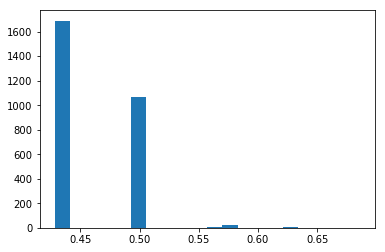

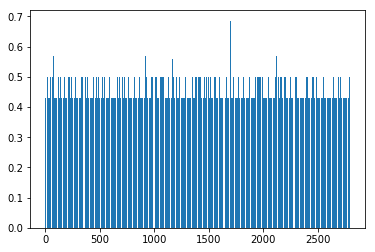

(2796, 2796, 2796)
(0.14145383104125736, 0.73469387755102045, 0.2372322899505766, None)
186


In [22]:
def print_details(label,THETA,LAMDA,SCORE):
    print(label)
    P_cap = get_P_cap(LAMDA,SCORE,THETA)
    marginals=get_marginals(P_cap)
    plt.hist(marginals, bins=20)
    plt.show()
    plt.bar(range(0,2796),marginals)
    plt.show()
    predicted_labels=predict_labels(marginals)
    print(len(marginals),len(predicted_labels),len(gold_labels_dev))
    #score(predicted_labels,gold_labels_dev)
    print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='binary')) 
    
def predict_labels(marginals):
    predicted_labels=[]
    for i in marginals:
        if(i<0.5):
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)
    return predicted_labels

import cPickle as pickle
THETA = pickle.load( open( "THETA.p", "rb" ) )
test(THETA)
LAMDA,SCORE = get_LAMDA(dev_cands)
Confidence = get_Confidence(LAMDA)

P_cap = get_P_cap(LAMDA,SCORE,THETA)
marginals=get_marginals(P_cap)
#plt.hist(marginals, bins=20)
#plt.show()
#plt.bar(range(0,888),train_marginals)
#plt.show()
predicted_labels=predict_labels(marginals)


sorted_predicted_labels=[x for (y,x) in sorted(zip(Confidence,predicted_labels))] #sort Labels as per Confidence
sorted_predicted_labels=list(reversed(sorted_predicted_labels))


#for i,j in enumerate(reversed(sorted(zip(Confidence,predicted_labels)))):
#    print i,sorted_predicted_labels[i],j
#print(len(marginals),len(predicted_labels),len(gold_labels_dev))
no_of_labels=186#int(len(predicted_labels)*0.1)  #54 - >0.2  , 108>= 0.15 , 186>= 0.12
print(len(sorted_predicted_labels[0:no_of_labels]))
#score(sorted_predicted_labels[0:no_of_labels],gold_labels_dev[0:no_of_labels])

In [ ]:
gold_labels_test = []
for i,L in enumerate(L_gold_test):
    gold_labels_test.append(L[0,0])
    
THETA = np.load('FTHETANPY.npy');
LAMDA,SCORE = get_LAMDA(test_cands)
Confidence = get_Confidence(LAMDA)

P_cap = get_P_cap(LAMDA,SCORE,THETA)
marginals=get_marginals(P_cap)
#plt.hist(marginals, bins=20)
#plt.show()
#plt.bar(range(0,888),train_marginals)
#plt.show()
predicted_labels=predict_labels(marginals)


sorted_predicted_labels=[x for (y,x) in sorted(zip(Confidence,predicted_labels))] #sort Labels as per Confidence
sorted_predicted_labels=list(reversed(sorted_predicted_labels))

for i,j in enumerate(reversed(sorted(zip(Confidence,predicted_labels)))):
    print i,sorted_predicted_labels[i],j
print(len(marginals),len(predicted_labels),len(gold_labels_test))
no_of_labels=186#int(len(predicted_labels)*0.1)  #54 - >0.2  , 108>= 0.15 , 186>= 0.12
print(len(sorted_predicted_labels[0:no_of_labels]))
score(sorted_predicted_labels[0:no_of_labels],gold_labels_test[0:no_of_labels])
score(sorted_predicted_labels,gold_labels_test)

In [ ]:
score(sorted_predicted_labels,gold_labels_test)

# Training Sparse Logistic Regression

In [21]:
train_marginals=load_marginals("train")

In [22]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.5,
    'print_freq': 1,
    'max_sentence_length': 100
}

lstm = reRNN(seed=1701, n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 17 has argument past max length for model:	[arg ends at index 146; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 18 has argument past max length for model:	[arg ends at index 117; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 19 has argument past max length for model:	[arg ends at index 146; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 22 has argument past max length for model:	[arg ends at index 117; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 23 has argument past ma

/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 18883 has argument past max length for model:	[arg ends at index 285; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 18888 has argument past max length for model:	[arg ends at index 122; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 18890 has argument past max length for model:	[arg ends at index 122; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 18892 has argument past max length for model:	[arg ends at index 122; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 18939 has a

/home/vinay/anaconda3/envs/en27/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=32  #epochs=10  batch size=32
[reRNN] Epoch 0 (0.80s)	Average loss=0.687072	Dev F1=13.23
[reRNN] Epoch 1 (15.27s)	Average loss=0.660101	Dev F1=13.13
[reRNN] Epoch 2 (29.61s)	Average loss=0.632739	Dev F1=13.10
[reRNN] Epoch 3 (43.97s)	Average loss=0.603334	Dev F1=13.10
[reRNN] Epoch 4 (57.90s)	Average loss=0.570051	Dev F1=13.10
[reRNN] Epoch 5 (71.63s)	Average loss=0.530517	Dev F1=13.10
[reRNN] Epoch 6 (85.59s)	Average loss=0.481146	Dev F1=13.10
[reRNN] Epoch 7 (99.49s)	Average loss=0.416199	Dev F1=13.10
[reRNN] Epoch 8 (113.17s)	Average loss=0.328013	Dev F1=13.10
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (127.67s)	Average loss=0.219741	Dev F1=13.10
[reRNN] Training done (140.42s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-8
[reRNN] Loaded model <reRNN>


In [23]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 233 has argument past max length for model:	[arg ends at index 148; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 234 has argument past max length for model:	[arg ends at index 132; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 235 has argument past max length for model:	[arg ends at index 148; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 236 has argument past max length for model:	[arg ends at index 148; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
/data1/vinay/snorkel/snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 238 has argument pa

Prec: 0.083, Recall: 1.000, F1 Score: 0.153


# Scoring on test set

In [ ]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)